### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

Using all embeddings, CLS and zero tokened. Stagnates at 77% acc on the residue level

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)


# Defining

Code for ProtBERT and BFD

In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-19 09:45:04.131969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-19 09:45:04.132127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorc

Changes from previous version: I am implementing COVID-19 classification with ProtTrans (Rostlab models) starting with the BFD

In [11]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding='max_length', max_length=140, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids, attention_mask=attention_mask)[0])
    embedding_pooled = np.asarray(embedding_model(input_ids, attention_mask=attention_mask)[1])
    print(embedding_model(input_ids)[0].shape) # Residue specific embeddings
    print(embedding_model(input_ids)[1].shape) # Pooled embeddings - they did not recommend to use
    residue_embeddings = [] # should be full, no cutting off. I don't think attention mask is used, also
    pooled_embeddings = [] 
    for seq_num in range(len(embedding)):
        pooled = embedding_pooled[seq_num]
        residues = embedding[seq_num]

        pooled_embeddings.append(pooled)
        residue_embeddings.append(residues)

    return np.asarray(pooled_embeddings), np.asarray(residue_embeddings)

In [12]:
sequences_Example = ["A E T C X A X","S K T X P"] # REMEMBER SPACING

In [13]:
pooled_embeddings, residue_embeddings = get_embeddings(sequences_Example)

NameError: name 'tokenizer' is not defined

In [6]:
# ids = tokenizer.batch_encode_plus(sequences_Example, add_special_tokens=True, padding=True, return_tensors="tf")
# embeddings = embedding_model.bert(ids['input_ids'], attention_mask=ids['attention_mask'])
# embeddings

In [7]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [8]:
tf.__version__

'2.10.0'

# Data Formatting

In [9]:
df = pd.read_csv("../Data/CoV-AbDab_201222.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
0,EVQLVESGGGLIQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLE...
1,EVQLVQSGGGLVQPGGSLRLSCLASGLTFSSYEFNWIRQAPGKGLE...
2,QVQLVQSGAEVKRPGASVKVLCMASGYSFTNYGINWVRQAPGQGLE...
3,EVQLVQSGAEVKKPRESLKISCKGSGYNFTSYWIGWVRQMPGKGLE...
4,EVQLVESGGGLVQPGGSLRLSCAASRFTFANYWMSWVRQAPGKGLE...
...,...
11999,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
12000,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
12001,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
12002,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [10]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11538:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11538


In [11]:
del head
del myfile
del dummy
gc.collect()

0

In [12]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

138
138


In [13]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [14]:
if os.path.exists('prot_bert_bfd_v3_embeddings') == False:
    os.mkdir('prot_bert_bfd_v3_embeddings')

In [15]:
print(round(len(covid_sequences) * 0.9999999))
print(round(len(covid_sequences) * 0.6666666))
print(round(len(covid_sequences) * 0.3333333))

11538
7692
3846


In [16]:
covid_sequences_1 = [(" ".join(s)) for s in covid_sequences][:round(len(covid_sequences) * 0.3)]
covid_sequences_2 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.3):round(len(covid_sequences) * 0.6)]
covid_sequences_3 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.6):round(len(covid_sequences) * 0.9)]
covid_sequences_4 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.9):]

In [17]:
covid_pooled_embeddings_1, covid_residue_embeddings_1 = get_embeddings(covid_sequences_1)

(3461, 140, 1024)
(3461, 1024)


In [18]:
with open("prot_bert_bfd_v3_embeddings/covid_1.pkl", "wb") as f:
    pickle.dump([covid_pooled_embeddings_1, covid_residue_embeddings_1], f)

del covid_sequences_1
del covid_pooled_embeddings_1
del covid_residue_embeddings_1
gc.collect()

0

In [19]:
covid_pooled_embeddings_2, covid_residue_embeddings_2 = get_embeddings(covid_sequences_2)

(3462, 140, 1024)
(3462, 1024)


In [20]:
with open("prot_bert_bfd_v3_embeddings/covid_2.pkl", "wb") as f:
    pickle.dump([covid_pooled_embeddings_2, covid_residue_embeddings_2], f)

del covid_sequences_2
del covid_pooled_embeddings_2
del covid_residue_embeddings_2
gc.collect()

0

In [21]:
covid_pooled_embeddings_3, covid_residue_embeddings_3 = get_embeddings(covid_sequences_3)

(3461, 140, 1024)
(3461, 1024)


In [22]:
with open("prot_bert_bfd_v3_embeddings/covid_3.pkl", "wb") as f:
    pickle.dump([covid_pooled_embeddings_3, covid_residue_embeddings_3], f)

del covid_sequences_3
del covid_pooled_embeddings_3
del covid_residue_embeddings_3
gc.collect()

0

In [23]:
covid_pooled_embeddings_4, covid_residue_embeddings_4 = get_embeddings(covid_sequences_4)

(1154, 140, 1024)
(1154, 1024)


In [24]:
with open("prot_bert_bfd_v3_embeddings/covid_4.pkl", "wb") as f:
    pickle.dump([covid_pooled_embeddings_4, covid_residue_embeddings_4], f)

del covid_sequences_4
del covid_pooled_embeddings_4
del covid_residue_embeddings_4
gc.collect()

0

In [25]:
healthy_sequences_1 = [(" ".join(s)) for s in healthy_sequences][:round(len(healthy_sequences) * 0.3)]
healthy_sequences_2 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.3):round(len(healthy_sequences) * 0.6)]
healthy_sequences_3 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.6):round(len(healthy_sequences) * 0.9)]
healthy_sequences_4 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.9):]

In [26]:
healthy_pooled_embeddings_1, healthy_residue_embeddings_1 = get_embeddings(healthy_sequences_1)

(3461, 140, 1024)
(3461, 1024)


In [27]:
with open("prot_bert_bfd_v3_embeddings/healthy_1.pkl", "wb") as f:
    pickle.dump([healthy_pooled_embeddings_1, healthy_residue_embeddings_1], f)

del healthy_sequences_1
del healthy_pooled_embeddings_1
del healthy_residue_embeddings_1
gc.collect()

0

In [28]:
healthy_pooled_embeddings_2, healthy_residue_embeddings_2 = get_embeddings(healthy_sequences_2)

(3462, 140, 1024)
(3462, 1024)


In [29]:
with open("prot_bert_bfd_v3_embeddings/healthy_2.pkl", "wb") as f:
    pickle.dump([healthy_pooled_embeddings_2, healthy_residue_embeddings_2], f)

del healthy_sequences_2
del healthy_pooled_embeddings_2
del healthy_residue_embeddings_2
gc.collect()

0

In [30]:
healthy_pooled_embeddings_3, healthy_residue_embeddings_3 = get_embeddings(healthy_sequences_3)

(3461, 140, 1024)
(3461, 1024)


In [31]:
with open("prot_bert_bfd_v3_embeddings/healthy_3.pkl", "wb") as f:
    pickle.dump([healthy_pooled_embeddings_3, healthy_residue_embeddings_3], f)

del healthy_sequences_3
del healthy_pooled_embeddings_3
del healthy_residue_embeddings_3
gc.collect()

0

In [32]:
healthy_pooled_embeddings_4, healthy_residue_embeddings_4 = get_embeddings(healthy_sequences_4)

(1154, 140, 1024)
(1154, 1024)


In [33]:
with open("prot_bert_bfd_v3_embeddings/healthy_4.pkl", "wb") as f:
    pickle.dump([healthy_pooled_embeddings_4, healthy_residue_embeddings_4], f)

del healthy_sequences_4
del healthy_pooled_embeddings_4
del healthy_residue_embeddings_4
gc.collect()

0

# Loading

In [2]:
covid_pooled_embeddings = [[None] * 1024]
covid_residue_embeddings = []

In [3]:
for i in range(1, 5):
    with open("prot_bert_bfd_v3_embeddings/covid_" + str(i) + ".pkl", "rb") as f:
        covid_temp = pickle.load(f)
        covid_pooled_embeddings = np.concatenate((covid_pooled_embeddings, covid_temp[0]))
        for j in covid_temp[1]:
            covid_residue_embeddings.append(j)
    f.close()

covid_pooled_embeddings = np.delete(covid_pooled_embeddings, 0, 0)

In [4]:
print(np.shape(covid_residue_embeddings))

(11538, 140, 1024)


In [5]:
healthy_pooled_embeddings = [[None] * 1024]
healthy_residue_embeddings = []

In [6]:
for i in range(1, 5):

    with open("prot_bert_bfd_v3_embeddings/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_pooled_embeddings = np.concatenate((healthy_pooled_embeddings, healthy_temp[0]))
        for j in healthy_temp[1]:
            healthy_residue_embeddings.append(j)
    f.close()

healthy_pooled_embeddings = np.delete(healthy_pooled_embeddings, 0, 0)

In [7]:
print(healthy_pooled_embeddings.shape)

(11538, 1024)


In [8]:
print(covid_pooled_embeddings)

[[-0.25066810846328735 -0.20758876204490662 0.2477787584066391 ...
  -0.24748606979846954 -0.25313079357147217 0.248740091919899]
 [-0.2548942565917969 -0.21134933829307556 0.25198644399642944 ...
  -0.25169533491134644 -0.25740206241607666 0.25294584035873413]
 [-0.24808910489082336 -0.20529600977897644 0.24521084129810333 ...
  -0.24491721391677856 -0.2505255937576294 0.2461732029914856]
 ...
 [-0.3266911506652832 -0.2756374776363373 0.32350024580955505 ...
  -0.3232370615005493 -0.32991084456443787 0.3244219124317169]
 [-0.324595183134079 -0.27374887466430664 0.32141178846359253 ...
  -0.3211478292942047 -0.327795147895813 0.32233479619026184]
 [-0.32339736819267273 -0.2726692259311676 0.3202182352542877 ...
  -0.3199537992477417 -0.3265863358974457 0.32114192843437195]]


In [9]:
print(np.shape(healthy_residue_embeddings))

(11538, 140, 1024)


In [10]:
healthy_lables = [0] * 11538
covid_lables = [1] * 11538

# Model 1: Residues (2D) (Change this to a CNN)

In [23]:
X = np.concatenate((healthy_residue_embeddings, covid_residue_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [45]:
del healthy_residue_embeddings
del covid_residue_embeddings
gc.collect()

470

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [47]:
del X
del y
gc.collect()

0

In [48]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [49]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(140, 1024)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.summary()

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (6, 6), activation='relu', input_shape=(140, 1024, 1)),
  tf.keras.layers.MaxPooling2D((2,3), padding='same'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,3), padding='same'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')

  # tf.keras.layers.Input((140, 1024)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM((512), return_sequences=True)),

  # tf.keras.layers.Dropout(0.2, seed=42),

  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),

  # tf.keras.layers.Dense(1024, activation='relu'),
  # tf.keras.layers.Dropout(0.3, seed=42),
  # tf.keras.layers.Dense(512, activation='relu'),
  # tf.keras.layers.Dense(256, activation='relu'),
  # tf.keras.layers.Dropout(0.3, seed=42),
  # tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dropout(0.3, seed=42),
  # tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(1, activation='sigmoid')

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 135, 1019, 64)     2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 68, 340, 64)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 68, 340, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 336, 64)       102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 112, 64)      0         
 2D)                                                             
                                                        

In [50]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [51]:
history = model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/50


2023-01-19 11:35:35.205093: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-19 11:35:35.768937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 8.8215e-06

2023-01-19 11:39:42.322065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - 253s 427ms/step - loss: 0.6835 - accuracy: 8.8215e-06 - val_loss: 0.4960 - val_accuracy: 0.7675
Epoch 2/50
585/585 [==============================] - 247s 422ms/step - loss: 0.6588 - accuracy: 0.5482 - val_loss: 0.4740 - val_accuracy: 0.7400
Epoch 3/50
585/585 [==============================] - 244s 418ms/step - loss: 0.6534 - accuracy: 0.5524 - val_loss: 0.4489 - val_accuracy: 0.7752
Epoch 4/50
585/585 [==============================] - 244s 418ms/step - loss: 0.6459 - accuracy: 0.5533 - val_loss: 0.4550 - val_accuracy: 0.7713
Epoch 5/50
585/585 [==============================] - 244s 417ms/step - loss: 0.6488 - accuracy: 0.5524 - val_loss: 0.4433 - val_accuracy: 0.7785
Epoch 6/50
585/585 [==============================] - 1216s 2s/step - loss: 0.6420 - accuracy: 0.5590 - val_loss: 0.4358 - val_accuracy: 0.7737
Epoch 7/50
585/585 [==============================] - 244s 418ms/step - loss: 0.6398 - accuracy: 0.5598 - val_loss: 0.4501 - val_accu

KeyboardInterrupt: 

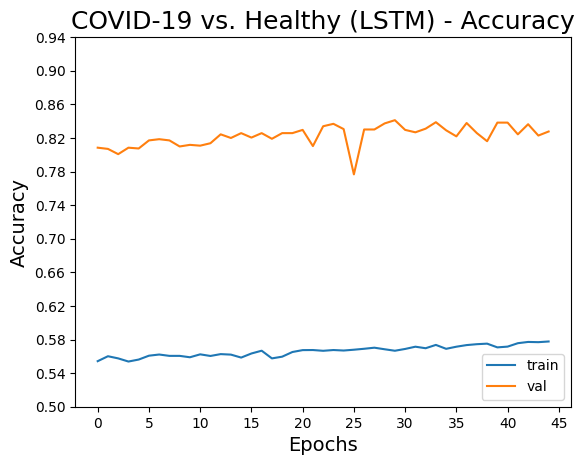

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('COVID-19 vs. Healthy (LSTM) - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.5, 0.96, 0.04))
plt.xticks(np.arange(0, 46, 5.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 1 Testing

In [ ]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 7s 98ms/step - loss: 0.5375 - accuracy: 0.8150


[0.5375497937202454, 0.8149913549423218]

In [ ]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

2023-01-06 08:35:37.004863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 08:35:37.205934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 08:35:37.222943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 08:35:38.467292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 08:35:38.481929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 87ms/step


[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([

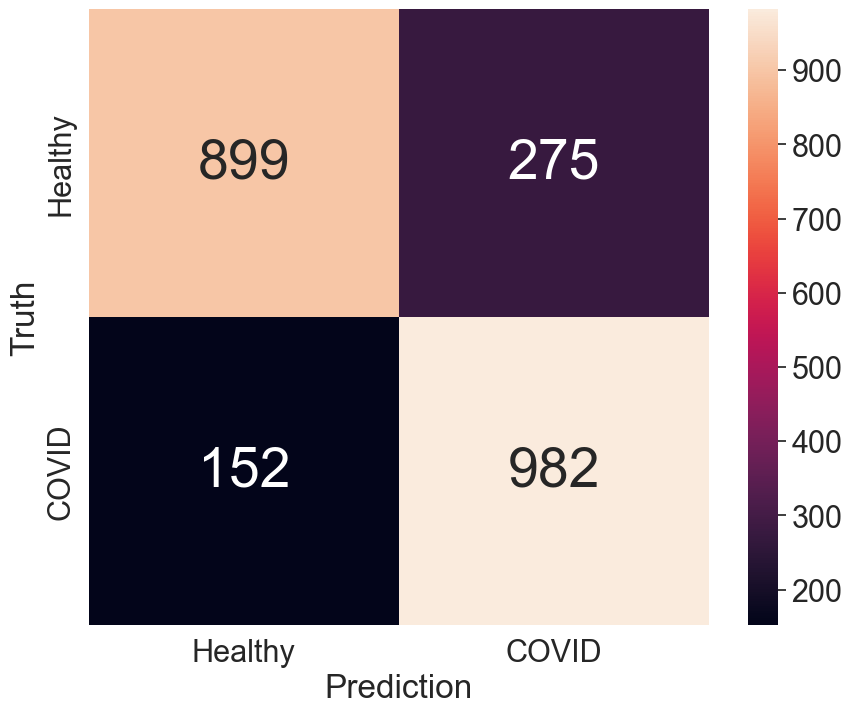

tf.Tensor(
[[899 275]
 [152 982]], shape=(2, 2), dtype=int32)


In [ ]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [ ]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

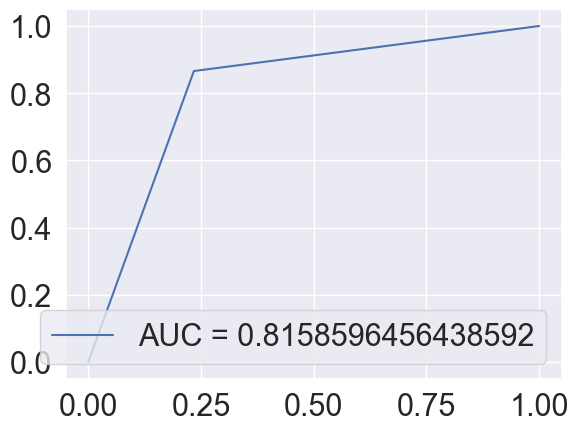

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

# Model 2: Pooled Embeddings

In [11]:
X = np.concatenate((healthy_pooled_embeddings, covid_pooled_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [12]:
del healthy_pooled_embeddings
del covid_pooled_embeddings
gc.collect()

0

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [14]:
del X
del y
gc.collect()

0

In [15]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 384)               196992    
                                        

2023-01-19 17:50:03.652855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-19 17:50:03.653000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [18]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    mode='auto',
    restore_best_weights=True,
)

In [19]:
history = model.fit(X_train, y_train, epochs=200, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/200


2023-01-19 17:50:06.411342: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-19 17:50:06.763849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.4982

2023-01-19 17:50:13.414048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - 7s 12ms/step - loss: 0.6940 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.5118
Epoch 2/200
585/585 [==============================] - 6s 11ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4882
Epoch 3/200
585/585 [==============================] - 6s 11ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4882
Epoch 4/200
585/585 [==============================] - 6s 11ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4882
Epoch 5/200
585/585 [==============================] - 6s 11ms/step - loss: 0.6933 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.4882
Epoch 6/200
585/585 [==============================] - 6s 11ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4882
Epoch 7/200
585/585 [==============================] - 6s 11ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4882
Epoc

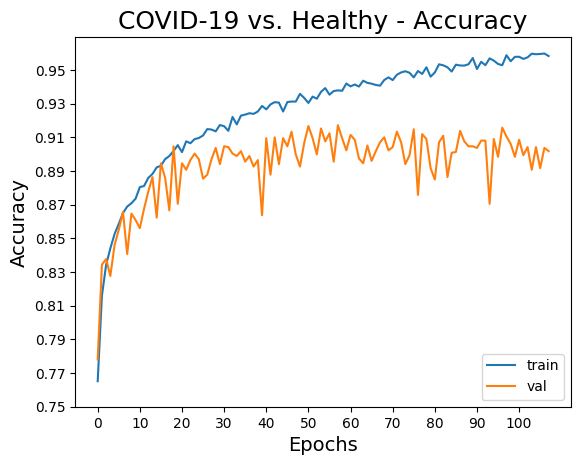

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('COVID-19 vs. Healthy (FNN) - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 0.96, 0.02))
plt.xticks(np.arange(0, 108, 10.0)) # this upper bound subject to change
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 2 Testing

In [ ]:
model.save("prot_berd_bfd_v3.h5")

In [ ]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 1s 8ms/step - loss: 0.2110 - accuracy: 0.9185


[0.21102690696716309, 0.9185441732406616]

In [ ]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 15ms/step


2023-01-11 10:12:21.106757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 18ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

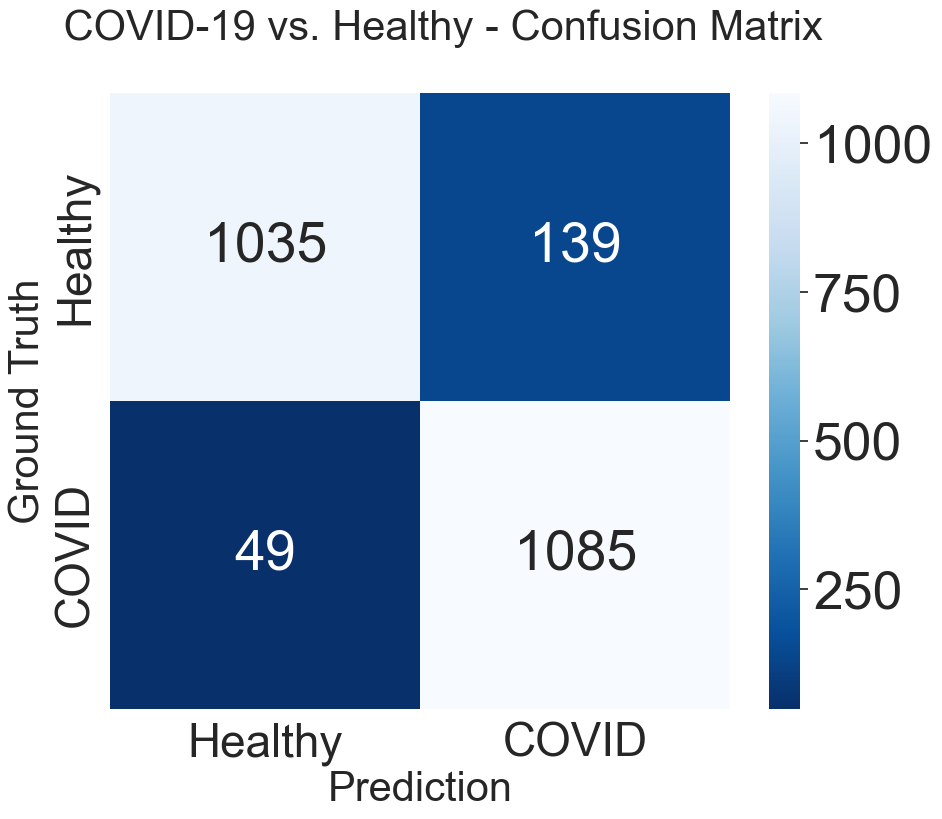

tf.Tensor(
[[1035  139]
 [  49 1085]], shape=(2, 2), dtype=int32)


In [ ]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    COVID-19 vs. Healthy - Confusion Matrix\n', fontsize=30)
sns.set(font_scale=3.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

In [ ]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

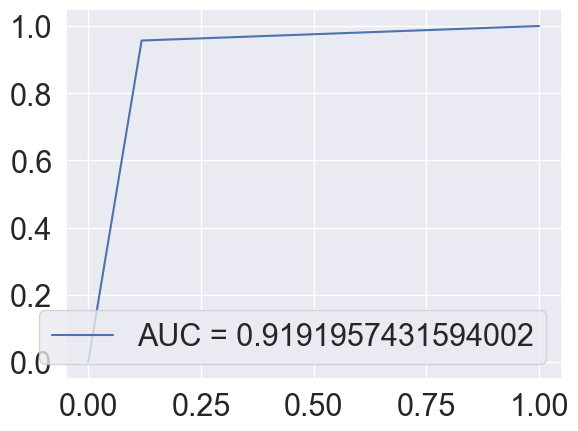

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()